<a href="https://colab.research.google.com/github/redhaanggara21/zeni-portofolio/blob/master/Tesis_Project_preProcessingwithMasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import pandas
from skimage import feature
from google.colab.patches import cv2_imshow
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = ('/content/drive/MyDrive/Tesis/Dataset/raw/')
output_path = ('/content/drive/MyDrive/Tesis/Dataset/messidor_outputMaskBlurred/')
size = (256, 256)

In [ ]:
def image_resize(image,size):
    return cv2.resize(image,size,interpolation=cv2.INTER_AREA)

In [ ]:
def convert_to_grayscale(image):
    resize = image_resize(image,size)
    gray =  cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
    return gray

In [ ]:
def detect_optical_disk(image,size):
    _, thresh = cv2.threshold(image, 170, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Total kontur ditemukan: {len(contours)}")

    min_area = (size[0] * size[1]) * 0.002
    valid_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        print("Area:", area, "Min area:", min_area)
        if area <= min_area:
           print(f"[SKIP] Area terlalu kecil: {area:.2f} < {min_area:.2f}")
           continue  # langsung skip ke kontur berikutnya

        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        extent = area / (w * h)

        if not (0.35 < aspect_ratio < 1.5):
           print(f"[SKIP] Aspect Ratio tidak valid: {aspect_ratio:.2f}")
           continue

        if extent <= 0.3:
           print(f"[SKIP] Extent terlalu kecil: {extent:.2f}")
           continue

        print(f"Total kontur ditemukan: {len(contours)}")
        print(f"[PASS] Area: {area:.2f}, Aspect Ratio: {aspect_ratio:.2f}, Extent: {extent:.2f}")
        valid_contours.append(cnt)

    if valid_contours:
        largest = max(valid_contours, key=cv2.contourArea)
        print("Kontur valid ketemu")
        return valid_contours, largest
    else:
        print("Tidak ada kontur valid ditemukan.")
        return [], None


In [ ]:
def mask_optical_disk(image):
    contours, largest_contour = detect_optical_disk(image,size)
    if largest_contour is not None:
        mask = np.ones_like(image, dtype=np.uint8) * 255
        cv2.drawContours(mask, [largest_contour], -1, 0, thickness=cv2.FILLED)
        masked = cv2.bitwise_and(image, image, mask=mask)
        return masked
    else:
        # return image, np.ones_like(image, dtype=np.uint8) * 255
        return image
        # raise ValueError("Kontur Tidak Ditemukan")

In [ ]:
def apply_gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)


In [ ]:
def clahe_image(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(image)
    return equalized

In [ ]:
def extract_lbp_features(pathImage):
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(pathImage, n_points, radius, method='uniform')
    mask = pathImage > 0
    lbp_masked =  lbp[mask]
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalisasi
    return hist

In [ ]:
# def preprocess_and_save_image(image_path, output_folder):
#     image = cv2.imread(image_path)
#     if image is None:
#         print(f"Failed to read: {image_path}")
#         return None

#     gray = convert_to_grayscale(image)
#     masked = mask_optical_disk(gray)
#     blurred = apply_gaussian_blur(masked)

#     # Create output file name
#     file_name = os.path.splitext(os.path.basename(image_path))[0] + "_pre-processing.png"
#     output_path = os.path.join(output_folder, file_name)

#     # Save the processed image
#     success = cv2.imwrite(output_path, blurred)

#     if success:
#       print(f"Saved: {output_path}")
#     else:
#       print(f"Failed to save: {output_path}")

#     return blurred.ravel()

In [ ]:
def preprocess_and_extract_features(image_path, output_folder):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read: {image_path}")
        return None

    gray = convert_to_grayscale(image)
    clahe = clahe_image(gray)
    # masked = mask_optical_disk(clahe)
    # if len(masked.shape) == 3:
    #     masked = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    # blurred = apply_gaussian_blur(clahe)
    blurred = apply_gaussian_blur(clahe)
    mask= mask_optical_disk(blurred)
    # Simpan gambar hasil preprocessing
    file_name = os.path.splitext(os.path.basename(image_path))[0] + "_pre-processing.png"
    output_path = os.path.join(output_folder, file_name)
    success = cv2.imwrite(output_path, mask)

    if success:
        print(f"Saved: {output_path}")
    else:
        print(f"Failed to save: {output_path}")

    # Ekstraksi fitur LBP
    return extract_lbp_features(mask)

In [ ]:
def load_and_preprocess_dataset(dataset_path, output_folder):
    if not os.path.exists(output_folder):
       os.makedirs(output_folder)

    images = []
    labels = []
    for label_folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, label_folder)
        output_label_folder = os.path.join(output_folder, label_folder)
        if not os.path.exists(output_label_folder):
            os.makedirs(output_label_folder)

        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    processed_image = preprocess_and_extract_features(file_path, output_label_folder)
                    images.append(processed_image)
                    labels.append(int(label_folder))  # Assuming folder name is the label
    return np.array(images), np.array(labels)


In [ ]:
X, y = load_and_preprocess_dataset(image_path, output_path)
if len(X) == 0 or len(y) == 0:
   raise ValueError("Dataset is empty. Check the dataset path and preprocessing steps.")


Streaming output truncated to the last 5000 lines.
Area: 6.5 Min area: 131.072
[SKIP] Area terlalu kecil: 6.50 < 131.07
Area: 15.5 Min area: 131.072
[SKIP] Area terlalu kecil: 15.50 < 131.07
Area: 0.0 Min area: 131.072
[SKIP] Area terlalu kecil: 0.00 < 131.07
Area: 31.5 Min area: 131.072
[SKIP] Area terlalu kecil: 31.50 < 131.07
Area: 35.0 Min area: 131.072
[SKIP] Area terlalu kecil: 35.00 < 131.07
Kontur valid ketemu
Saved: /content/drive/MyDrive/Tesis/Dataset/messidor_outputMaskBlurred/1/20060411_61548_0200_PP_pre-processing.png
Total kontur ditemukan: 5
Area: 8.0 Min area: 131.072
[SKIP] Area terlalu kecil: 8.00 < 131.07
Area: 0.5 Min area: 131.072
[SKIP] Area terlalu kecil: 0.50 < 131.07
Area: 0.0 Min area: 131.072
[SKIP] Area terlalu kecil: 0.00 < 131.07
Area: 250.0 Min area: 131.072
[SKIP] Aspect Ratio tidak valid: 0.33
Area: 4.0 Min area: 131.072
[SKIP] Area terlalu kecil: 4.00 < 131.07
Tidak ada kontur valid ditemukan.
Saved: /content/drive/MyDrive/Tesis/Dataset/messidor_output

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
print("Feature Importances:", importances)
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

Feature Importances: [0.09454744 0.10360086 0.09922829 0.10321752 0.09809317 0.08834811
 0.09669286 0.10960924 0.09712594 0.10953658]


In [ ]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train_selected, y_train)
y_pred = lgbm.predict(X_test_selected)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 4
[LightGBM] [Info] Start training from score -0.546088
[LightGBM] [Info] Start training from score -0.919881
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5730659025787965
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67       213
           1       0.44      0.38      0.41       132
           2       0.00      0.00      0.00         4

    accuracy                           0.57       349
   macro avg       0.36      0.36      0.36       349
weighted avg       0.56      0.57      0.56       349



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


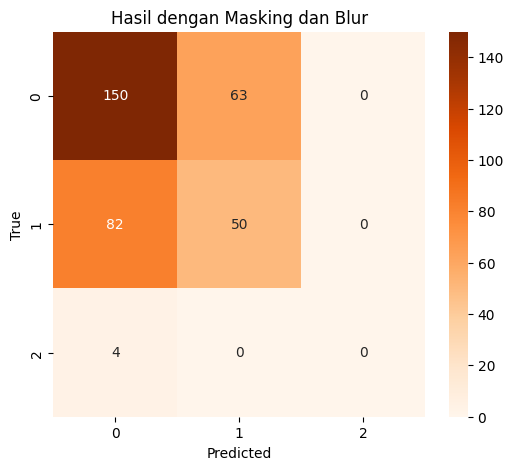

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Hasil dengan Masking dan Blur")
plt.show()